# Análisis del riesgo de incumplimiento de los prestatarios

<div style="background-color: #ADD8E6; padding: 10px;">
En este proyecto, analizaremos un conjunto de datos sobre la solvencia crediticia de los clientes del banco.
El análisis será utilizado para crear una <b>puntuación de crédito</b> para potenciales clientes, mejorando así el proceso de evaluación de crédito. 
Nuestro objetivo es identificar posibles conexiones entre las variables y el cumplimiento de pagos.
El enfoque se divide en dos etapas principales: el <b>preprocesamiento de datos</b> para asegurar su calidad y la respuesta a <b>preguntas claves</b> sobre la relación entre <i>tener hijos</i>, el <i>estado civil</i>, el <i>nivel de ingresos</i> y el <i>propósito del préstamo</i> con el pago a tiempo.

## Abre el archivo de datos y mira la información general. 

In [1]:
# Cargar todas las librerías

import pandas as pd 
import numpy as np
import re
from IPython.display import display
from IPython.display import Image

In [2]:
# Cargar los datos

df = pd.read_csv('./credit_scoring_eng.csv')

## Exploración de datos

**Descripción de los datos**
- `children` - el número de hijos en la familia
- `days_employed` - experiencia laboral en días
- `dob_years` - la edad del cliente en años
- `education` - la educación del cliente
- `education_id` - identificador de educación
- `family_status` - estado civil
- `family_status_id` - identificador de estado civil
- `gender` - género del cliente
- `income_type` - tipo de empleo
- `debt` - ¿había alguna deuda en el pago de un préstamo?
- `total_income` - ingreso mensual
- `purpose` - el propósito de obtener un préstamo

In [3]:
# Numero de filas y columnas del conjunto de datos

print('Columnas:', df.shape[1])
print('Filas:', df.shape[0])

Columnas: 12
Filas: 21525


In [4]:
# Mostrar las primeras 10 filas del conjunto 

df.head(10) 

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding
5,0,-926.185831,27,bachelor's degree,0,civil partnership,1,M,business,0,40922.170,purchase of the house
6,0,-2879.202052,43,bachelor's degree,0,married,0,F,business,0,38484.156,housing transactions
7,0,-152.779569,50,SECONDARY EDUCATION,1,married,0,M,employee,0,21731.829,education
8,2,-6929.865299,35,BACHELOR'S DEGREE,0,civil partnership,1,F,employee,0,15337.093,having a wedding
9,0,-2188.756445,41,secondary education,1,married,0,M,employee,0,23108.150,purchase of the house for my family


<div style="background-color: #ADD8E6; padding: 10px;">
<li>Aparecen <b>valores negativos</b> en la columna <code>days_employed</code>, sería necesario averiguar si es un problema
<li>Probable que se refiera a las diferentes <b>condiciones laborales</b> de los clientes
<li>Los <b>valores numéricos</b> en <code>days_employed</code> parecen fuera del rango
<li>Al analizar la columna <code>education</code> y <code>purpose</code> se nota la presencia de <b>registros duplicados</b>
<li>Tendríamos que construir un <b>diccionario de remplazos</b>

In [5]:
# Obtener información sobre los datos

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


<div style="background-color: #ADD8E6; padding: 10px;">
<li>En el conjunto de datos se encuentran <b>21525</b> entradas, divididas entre <i>objetos</i> y <i>números enteros</i>
<li>Sin embargo, en las columnas <code>days_employed</code> y <code>total_income</code> solo se encuentran <b>19351</b> entradas, las cuales son <i>números flotantes</i>

In [6]:
# Mostrar la tabla filtrada con valores ausentes en days_employed

df_filtrado = df[df['days_employed'].isnull()]
df_filtrado

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,secondary education,1,civil partnership,1,M,retiree,0,NaN,to have a wedding
26,0,NaN,41,secondary education,1,married,0,M,civil servant,0,NaN,education
29,0,NaN,63,secondary education,1,unmarried,4,F,retiree,0,NaN,building a real estate
41,0,NaN,50,secondary education,1,married,0,F,civil servant,0,NaN,second-hand car purchase
55,0,NaN,54,secondary education,1,civil partnership,1,F,retiree,1,NaN,to have a wedding
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Secondary Education,1,married,0,M,business,0,NaN,purchase of a car
21495,1,NaN,50,secondary education,1,civil partnership,1,F,employee,0,NaN,wedding ceremony
21497,0,NaN,48,BACHELOR'S DEGREE,0,married,0,F,business,0,NaN,building a property
21502,1,NaN,42,secondary education,1,married,0,F,employee,0,NaN,building a real estate


<div style="background-color: #ADD8E6; padding: 10px;">
<li>El número de valores ausentes coincide en las columnas <code>days_employed</code> y <code>total_income</code>
<li>En las dos columnas se encuentran <b>2174</b> valores ausentes
<li>Deberíamos verificar la <b>coincidencia</b> de las filas con valores ausentes en ambas columnas
<li>La categoría <b>secondary education</b> en la columna <code>education</code> es común cuando faltan valores en <code>days_employed</code> y <code>total_income</code>
<li>Esto sugiere una posible <b>relación</b> entre la falta de información laboral y el nivel educativo secundario.
<li>La categoría <b>F</b> en la columna <code>gender</code> también es común cuando faltan valores en <code>days_employed</code> y <code>total_income</code> 

In [7]:
# Aplicar múltiples condiciones para filtrar datos y ver el número de filas en la tabla filtrada

df_filtrado = df[df['days_employed'].isnull() & df['total_income'].isnull()]
df_filtrado.shape[0]

2174

In [8]:
# Calcular el porcentaje de valores ausentes en `days_employed`

porcentaje_valores_ausentes = (df_filtrado.shape[0] / df.shape[0])
print("El porcentaje de los valores ausentes es: {:.2%}".format(porcentaje_valores_ausentes))

El porcentaje de los valores ausentes es: 10.10%


**Conclusión intermedia**

<div style="background-color: #ADD8E6; padding: 10px;">

<li>El número de filas en la tabla filtrada <b>coincide</b> con el número de valores ausentes
<li>Los <b>valores ausentes</b> se encuentran simultáneamente en <code>days_employed</code> y <code>total_income</code>
<li>Esta coincidencia puede indicar una <b>relación</b> o razón subyacente que causa la ausencia de datos en ambas columnas
<li>Los valores ausentes representan el <b>10,10%</b> del conjunto de datos
<li>Tendríamos que investigar más a fondo para determinar si hay un <b>patrón</b> que contribuye a los valores ausentes
<li>Un patrón se puede encontrar analizando los otros indicadores en las columnas con <b>características específicas</b> de los clientes
<li>Esto nos ayudará a tomar <b>decisiones informadas</b> sobre cómo manejar y completar los valores ausentes en nuestro análisis    
<div>    

In [9]:
# Investigar los clientes que no tienen datos sobre la característica identificada y la columna con los valores ausentes

filtered_df = df[df['days_employed'].isnull()& (df['education'] == 'secondary education')]
display(filtered_df)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,secondary education,1,civil partnership,1,M,retiree,0,NaN,to have a wedding
26,0,NaN,41,secondary education,1,married,0,M,civil servant,0,NaN,education
29,0,NaN,63,secondary education,1,unmarried,4,F,retiree,0,NaN,building a real estate
41,0,NaN,50,secondary education,1,married,0,F,civil servant,0,NaN,second-hand car purchase
55,0,NaN,54,secondary education,1,civil partnership,1,F,retiree,1,NaN,to have a wedding
...,...,...,...,...,...,...,...,...,...,...,...,...
21423,0,NaN,63,secondary education,1,married,0,M,retiree,0,NaN,purchase of a car
21426,0,NaN,49,secondary education,1,married,0,F,employee,1,NaN,property
21495,1,NaN,50,secondary education,1,civil partnership,1,F,employee,0,NaN,wedding ceremony
21502,1,NaN,42,secondary education,1,married,0,F,employee,0,NaN,building a real estate


<div style="background-color: #ADD8E6; padding: 10px;">

<li>Encontré que de las <b>2174</b> filas con valores ausentes en <code>days_employed</code>, en <b>1408</b> de ellas la categoría de <code>education</code> es <b>secondary education</b>
<li>Esto sugiere una <b>posible asociación</b> entre la falta de información laboral y un nivel de educación secundaria
<li>Por lo menos, podría facilitar una <b>imputación multivariada</b> de los valores ausentes

In [10]:
# Comprobación de la distribución

df_by_education = df.groupby("education")
count_by_education = df_by_education.count()
display(count_by_education)

,children,days_employed,dob_years,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
education,,,,,,,,,,,
BACHELOR'S DEGREE,274,251,274,274,274,274,274,274,274,251,274
Bachelor's Degree,268,243,268,268,268,268,268,268,268,243,268
GRADUATE DEGREE,1,1,1,1,1,1,1,1,1,1,1
Graduate Degree,1,1,1,1,1,1,1,1,1,1,1
PRIMARY EDUCATION,17,16,17,17,17,17,17,17,17,16,17
Primary Education,15,14,15,15,15,15,15,15,15,14,15
SECONDARY EDUCATION,772,705,772,772,772,772,772,772,772,705,772
SOME COLLEGE,29,22,29,29,29,29,29,29,29,22,29
Secondary Education,711,646,711,711,711,711,711,711,711,646,711


**Posibles razones por las que hay valores ausentes en los datos**

<div style="background-color: #ADD8E6; padding: 10px;">

Las posibles razones para la falta de valores en las columnas <code>days_employed</code> y <code>total_income</code> podrían ser <b>errores en la recopilación</b> de datos, <b>características específicas</b> de ciertos grupos de clientes y la <b>omisión intencional</b> de la información laboral. Podemos realizar un análisis comparando la presencia de valores ausentes en diferentes grupos o categorías, como <i>educación</i>, <i>estado civil</i>, <i>género</i> o <i>tipo de ingreso</i>. Si no encontramos patrones o tendencias claras entre estas características y los valores ausentes, es probable que los valores ausentes sean <b>aleatorios</b> en el conjunto de datos.

In [11]:
# Comprobar la distribución en el conjunto de datos entero
        
for column in df.columns:
    if column in ['days_employed', 'total_income']:
        continue
    df_grouped = df.groupby(column)
    count_by_column = df_grouped.count()
    display(count_by_column)

,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
children,,,,,,,,,,,
-1,44,47,47,47,47,47,47,47,47,44,47
0,12710,14149,14149,14149,14149,14149,14149,14149,14149,12710,14149
1,4343,4818,4818,4818,4818,4818,4818,4818,4818,4343,4818
2,1851,2055,2055,2055,2055,2055,2055,2055,2055,1851,2055
3,294,330,330,330,330,330,330,330,330,294,330
4,34,41,41,41,41,41,41,41,41,34,41
5,8,9,9,9,9,9,9,9,9,8,9
20,67,76,76,76,76,76,76,76,76,67,76


,children,days_employed,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
dob_years,,,,,,,,,,,
0,101,91,101,101,101,101,101,101,101,91,101
19,14,13,14,14,14,14,14,14,14,13,14
20,51,46,51,51,51,51,51,51,51,46,51
21,111,93,111,111,111,111,111,111,111,93,111
22,183,166,183,183,183,183,183,183,183,166,183
23,254,218,254,254,254,254,254,254,254,218,254
24,264,243,264,264,264,264,264,264,264,243,264
25,357,334,357,357,357,357,357,357,357,334,357
26,408,373,408,408,408,408,408,408,408,373,408


,children,days_employed,dob_years,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
education,,,,,,,,,,,
BACHELOR'S DEGREE,274,251,274,274,274,274,274,274,274,251,274
Bachelor's Degree,268,243,268,268,268,268,268,268,268,243,268
GRADUATE DEGREE,1,1,1,1,1,1,1,1,1,1,1
Graduate Degree,1,1,1,1,1,1,1,1,1,1,1
PRIMARY EDUCATION,17,16,17,17,17,17,17,17,17,16,17
Primary Education,15,14,15,15,15,15,15,15,15,14,15
SECONDARY EDUCATION,772,705,772,772,772,772,772,772,772,705,772
SOME COLLEGE,29,22,29,29,29,29,29,29,29,22,29
Secondary Education,711,646,711,711,711,711,711,711,711,646,711


,children,days_employed,dob_years,education,family_status,family_status_id,gender,income_type,debt,total_income,purpose
education_id,,,,,,,,,,,
0,5260,4716,5260,5260,5260,5260,5260,5260,5260,4716,5260
1,15233,13693,15233,15233,15233,15233,15233,15233,15233,13693,15233
2,744,675,744,744,744,744,744,744,744,675,744
3,282,261,282,282,282,282,282,282,282,261,282
4,6,6,6,6,6,6,6,6,6,6,6


,children,days_employed,dob_years,education,education_id,family_status_id,gender,income_type,debt,total_income,purpose
family_status,,,,,,,,,,,
civil partnership,4177,3735,4177,4177,4177,4177,4177,4177,4177,3735,4177
divorced,1195,1083,1195,1195,1195,1195,1195,1195,1195,1083,1195
married,12380,11143,12380,12380,12380,12380,12380,12380,12380,11143,12380
unmarried,2813,2525,2813,2813,2813,2813,2813,2813,2813,2525,2813
widow / widower,960,865,960,960,960,960,960,960,960,865,960


,children,days_employed,dob_years,education,education_id,family_status,gender,income_type,debt,total_income,purpose
family_status_id,,,,,,,,,,,
0,12380,11143,12380,12380,12380,12380,12380,12380,12380,11143,12380
1,4177,3735,4177,4177,4177,4177,4177,4177,4177,3735,4177
2,960,865,960,960,960,960,960,960,960,865,960
3,1195,1083,1195,1195,1195,1195,1195,1195,1195,1083,1195
4,2813,2525,2813,2813,2813,2813,2813,2813,2813,2525,2813


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,income_type,debt,total_income,purpose
gender,,,,,,,,,,,
F,14236,12752,14236,14236,14236,14236,14236,14236,14236,12752,14236
M,7288,6598,7288,7288,7288,7288,7288,7288,7288,6598,7288
XNA,1,1,1,1,1,1,1,1,1,1,1


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,debt,total_income,purpose
income_type,,,,,,,,,,,
business,5085,4577,5085,5085,5085,5085,5085,5085,5085,4577,5085
civil servant,1459,1312,1459,1459,1459,1459,1459,1459,1459,1312,1459
employee,11119,10014,11119,11119,11119,11119,11119,11119,11119,10014,11119
entrepreneur,2,1,2,2,2,2,2,2,2,1,2
paternity / maternity leave,1,1,1,1,1,1,1,1,1,1,1
retiree,3856,3443,3856,3856,3856,3856,3856,3856,3856,3443,3856
student,1,1,1,1,1,1,1,1,1,1,1
unemployed,2,2,2,2,2,2,2,2,2,2,2


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,total_income,purpose
debt,,,,,,,,,,,
0,19784,17780,19784,19784,19784,19784,19784,19784,19784,17780,19784
1,1741,1571,1741,1741,1741,1741,1741,1741,1741,1571,1741


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income
purpose,,,,,,,,,,,
building a property,620,561,620,620,620,620,620,620,620,620,561
building a real estate,626,580,626,626,626,626,626,626,626,626,580
buy commercial real estate,664,597,664,664,664,664,664,664,664,664,597
buy real estate,624,552,624,624,624,624,624,624,624,624,552
buy residential real estate,607,546,607,607,607,607,607,607,607,607,546
buying a second-hand car,479,437,479,479,479,479,479,479,479,479,437
buying my own car,505,452,505,505,505,505,505,505,505,505,452
buying property for renting out,653,588,653,653,653,653,653,653,653,653,588
car,495,454,495,495,495,495,495,495,495,495,454


    
**Conclusión intermedia**

<div style="background-color: #ADD8E6; padding: 10px;">

Se encontró una posible asociación entre la falta de información laboral en <code>days_employed</code> y el nivel de educación secundaria en <code>education</code>. Sin embargo, <b>no hubo patrones claros</b> de relación con otras variables. La distribución en la tabla filtrada difiere del conjunto de datos original en los valores ausentes de <code>days_employed</code>, hay valores ausentes en todas las categorías.

    
**Conclusión intermedia**


In [12]:
# Contar los valores positivos en days_employed

count_positive = df[df['days_employed'] > 0]['days_employed'].count()
print("Número de valores mayores a 0 en 'days_employed':", count_positive)

Número de valores mayores a 0 en 'days_employed': 3445


In [13]:
# Comprobación de otros patrones: los valores positivos se refieren a clientes jubilados

filas_filtradas_retiree = df[(df['days_employed'] > 0) & (df['income_type'] == 'retiree')]
filas_filtradas_retiree

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding
18,0,400281.136913,53,secondary education,1,widow / widower,2,F,retiree,0,9091.804,buying a second-hand car
24,1,338551.952911,57,secondary education,1,unmarried,4,F,retiree,0,46487.558,transactions with commercial real estate
25,0,363548.489348,67,secondary education,1,married,0,M,retiree,0,8818.041,buy real estate
30,1,335581.668515,62,secondary education,1,married,0,F,retiree,0,27432.971,transactions with commercial real estate
...,...,...,...,...,...,...,...,...,...,...,...,...
21505,0,338904.866406,53,secondary education,1,civil partnership,1,M,retiree,0,12070.399,to have a wedding
21508,0,386497.714078,62,secondary education,1,married,0,M,retiree,0,11622.175,property
21509,0,362161.054124,59,bachelor's degree,0,married,0,M,retiree,0,11684.650,real estate transactions
21518,0,373995.710838,59,SECONDARY EDUCATION,1,married,0,F,retiree,0,24618.344,purchase of a car


In [14]:
# Comprobación de otros patrones: también se refieren a clientes sin empleo

filas_filtradas_unemployed = df[(df['days_employed'] > 0) & (df['income_type'] == 'unemployed')]
filas_filtradas_unemployed

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
3133,1,337524.466835,31,secondary education,1,married,0,M,unemployed,1,9593.119,buying property for renting out
14798,0,395302.838654,45,Bachelor's Degree,0,civil partnership,1,F,unemployed,0,32435.602,housing renovation


In [15]:
# Crear un DataFrame sin datos nulos

df_sin_nulos = df.dropna()

# Variables categóricas para comparar
variables_categoricas = ['income_type', 'family_status', 'gender']

# Comparación de distribuciones para cada variable categórica
for variable in variables_categoricas:
    print(f"--- Distribución para la variable '{variable}' ---")
    print("Con datos nulos:")
    print(df[variable].value_counts(normalize=True))
    print('-'*40)
    print("Sin datos nulos:")
    print(df_sin_nulos[variable].value_counts(normalize=True))
    print("\n")

--- Distribución para la variable 'income_type' ---
Con datos nulos:
employee                       0.516562
business                       0.236237
retiree                        0.179141
civil servant                  0.067782
unemployed                     0.000093
entrepreneur                   0.000093
student                        0.000046
paternity / maternity leave    0.000046
Name: income_type, dtype: float64
----------------------------------------
Sin datos nulos:
employee                       0.517493
business                       0.236525
retiree                        0.177924
civil servant                  0.067800
unemployed                     0.000103
student                        0.000052
entrepreneur                   0.000052
paternity / maternity leave    0.000052
Name: income_type, dtype: float64


--- Distribución para la variable 'family_status' ---
Con datos nulos:
married              0.575145
civil partnership    0.194053
unmarried            0.130685
di


**Conclusiones**


<div style="background-color: #ADD8E6; padding: 10px;">

Es interesante observar que los <b>valores negativos</b> en la columna <code>days_employed</code> parecen estar relacionados con los <b>valores categóricos</b> en la columna <code>income_type</code>. Específicamente, todos los valores positivos en <code>days_employed</code> coinciden con clientes jubilados y sin empleo. Mientras que las otras condiciones laborales son representadas con valores negativos. Sin embargo, la <b>falta de patrones</b> claros en relación a los valores ausentes permite considerar la opción de imputar los valores faltantes en variables numéricas. Es importante abordar problemas como <b>duplicados</b>, <b>inconsistencias en registros</b> y <b>artefactos incorrectos</b>, corrigiendo los diccionarios de categorías para mejorar la calidad y consistencia de los datos.

## Transformación de datos

In [16]:
# Mostrar todos los valores en la columna `education` para verificar si es necesario corregir los registros

unique_values = df['education'].unique()
unique_values

array(["bachelor's degree", 'secondary education', 'Secondary Education',
       'SECONDARY EDUCATION', "BACHELOR'S DEGREE", 'some college',
       'primary education', "Bachelor's Degree", 'SOME COLLEGE',
       'Some College', 'PRIMARY EDUCATION', 'Primary Education',
       'Graduate Degree', 'GRADUATE DEGREE', 'graduate degree'],
      dtype=object)

In [17]:
# Arreglar los registros

corrections = {
    "bachelor's degree": "bachelor_degree",
    'secondary education': 'secondary_education',
    'Secondary Education': 'secondary_education',
    'SECONDARY EDUCATION': 'secondary_education',
    "BACHELOR'S DEGREE": "bachelor_degree",
    'some college': 'some_college',
    'primary education': 'primary_education',
    "Bachelor's Degree": "bachelor_degree",
    'SOME COLLEGE': 'some_college',
    'Some College': 'some_college',
    'PRIMARY EDUCATION': 'primary_education',
    'Primary Education': 'primary_education',
    'Graduate Degree': 'graduate_degree',
    'GRADUATE DEGREE': 'graduate_degree',
    'graduate degree': 'graduate_degree'
}

df['education'] = df['education'].replace(corrections)

In [18]:
# Mostrar los valores corregidos

unique_values = df['education'].unique()
unique_values

array(['bachelor_degree', 'secondary_education', 'some_college',
       'primary_education', 'graduate_degree'], dtype=object)

In [19]:
# Mostrar la distribución de los valores en la columna `children`

conteo_children = df['children'].value_counts()
conteo_children

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

<div style="background-color: #ADD8E6; padding: 10px;">

<li>Los valores 0 en <code>children</code> indican la <b>ausencia de hijos</b>
<li>Los valores -1 parecen ser <b>errores</b> de recopilación o ingreso de datos incorrectos
<li>Los valores 20 también parecen ser <b>errores</b> de recopilación o ingreso de datos incorrectos
<li>Estos valores difieren demasiado de la media, así que sería mejor <b>imputarlos</b>

In [20]:
# Imputación de los valores incorrectos

df['children'] = df['children'].replace([-1, 20], [1, 2])

In [21]:
# Comprobar la columna `children`

conteo_children = df['children'].value_counts()
conteo_children

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

In [22]:
# Encontrar datos problemáticos en `days_employed` y calcular el porcentaje

positive_values = df[df['days_employed'] >= 0]['days_employed']
mean_positive = positive_values.mean()
negative_values = df[df['days_employed'] < 0]['days_employed'] * -1
mean_negative = negative_values.mean()

total_rows = len(df)
negative_rows = df.loc[df['days_employed'] < 0]
negative_count = len(negative_rows)
percentage_negative = (negative_count / total_rows) * 100

total_rows = len(df)
missing_rows = df['days_employed'].isnull().sum()
missing_percentage = (missing_rows / total_rows) * 100


print(type(df['days_employed']))
print()
print("Resumen Estadístico 'days_employed'")
display(df['days_employed'].describe())
print('-'*45)
print("Media de valores positivos:", mean_positive)
print("Media de valores negativos:", mean_negative)
print(f"Porcentaje de valores ausentes en 'days_employed': {missing_percentage:.2f}%")
print("Porcentaje de valores negativos en 'days_employed': {:.2f}%".format(percentage_negative))

<class 'pandas.core.series.Series'>

Resumen Estadístico 'days_employed'


count     19351.000000
mean      63046.497661
std      140827.311974
min      -18388.949901
25%       -2747.423625
50%       -1203.369529
75%        -291.095954
max      401755.400475
Name: days_employed, dtype: float64

---------------------------------------------
Media de valores positivos: 365004.3099162686
Media de valores negativos: 2353.0159319988766
Porcentaje de valores ausentes en 'days_employed': 10.10%
Porcentaje de valores negativos en 'days_employed': 73.90%


<div style="background-color: #ADD8E6; padding: 10px;">

<li>Los <b>valores negativos</b> en <code>days_employed</code> representan casi el <b>74%</b> del conjunto
<li>Vamos a corregir esta tendencia para evitar que afecte negativamente a la investigación

In [23]:
# Abordar los valores problemáticos

df['days_employed'] = df['days_employed'].abs()

In [24]:
# Comprobar el resultado

positive_values = df[df['days_employed'] >= 0]['days_employed']
mean_positive = positive_values.mean()
negative_values = df[df['days_employed'] < 0]['days_employed'] * -1
mean_negative = negative_values.mean()

total_rows = len(df)
negative_rows = df.loc[df['days_employed'] < 0]
negative_count = len(negative_rows)
percentage_negative = (negative_count / total_rows) * 100

total_rows = len(df)
missing_rows = df['days_employed'].isnull().sum()
missing_percentage = (missing_rows / total_rows) * 100


print(type(df['days_employed']))
print()
print("Resumen Estadístico 'days_employed'")
display(df['days_employed'].describe())
print('-'*45)
print("Media de valores positivos:", mean_positive)
print("Media de valores negativos:", mean_negative)
print(f"Porcentaje de valores ausentes en 'days_employed': {missing_percentage:.2f}%")
print("Porcentaje de valores negativos en 'days_employed': {:.2f}%".format(percentage_negative))

<class 'pandas.core.series.Series'>

Resumen Estadístico 'days_employed'


count     19351.000000
mean      66914.728907
std      139030.880527
min          24.141633
25%         927.009265
50%        2194.220567
75%        5537.882441
max      401755.400475
Name: days_employed, dtype: float64

---------------------------------------------
Media de valores positivos: 66914.72890682236
Media de valores negativos: nan
Porcentaje de valores ausentes en 'days_employed': 10.10%
Porcentaje de valores negativos en 'days_employed': 0.00%


In [25]:
# Remplazar los valores incoherentes en 'days_employed' con NaN

df.loc[df['days_employed'] > 36500, 'days_employed'] = np.nan

In [26]:
# Revisar `dob_years` en busca de valores sospechosos

unique_values = sorted(df['dob_years'].unique())
print(unique_values)

[0, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]


In [27]:
# Contar el porcentaje de valores problemáticos

count_zero_dob_years = (df['dob_years'] == 0).sum()
percentage_zero_dob_years = (df['dob_years'] == 0).astype(int).mean() * 100

print(f"Número de filas con valor 0 en la columna 'dob_years': {count_zero_dob_years}")
print(f"Porcentaje de valores 0 en la columna 'dob_years': {percentage_zero_dob_years:.2f}%")

Número de filas con valor 0 en la columna 'dob_years': 101
Porcentaje de valores 0 en la columna 'dob_years': 0.47%


<div style="background-color: #ADD8E6; padding: 10px;">

<li>En la columna <code>dob_years</code>, se registra la <b>edad</b> de los clientes
<li>Se identificaron <b>101</b> entradas en las que la edad es igual a <b>0</b>
<li>Estas entradas representan solo el <b>0.47%</b> del total de datos
<li>Esto parece ser un <b>error</b> de recopilación o ingreso de datos incorrecto, ya que es poco probable que los clientes tengan una edad de 0
<li>Para abordar este problema, vamos a remplazar los valores 0 utilizando la <b>media</b> o la <b>mediana</b> de las edades registradas en el conjunto de datos.

In [28]:
# Solucionar los problemas en la columna `dob_years`

df_sin_cero = df[df['dob_years'] != 0]
mediana_sin_cero = df_sin_cero['dob_years'].median()

print("Resumen estadístico 'dob_years' sin tener en cuenta el valor 0:")
display(df_sin_cero['dob_years'].describe())
print('La mediana de las edades sin tener en cuenta el valor 0 es:', int(mediana_sin_cero))

Resumen estadístico 'dob_years' sin tener en cuenta el valor 0:


count    21424.000000
mean        43.497479
std         12.246934
min         19.000000
25%         33.000000
50%         43.000000
75%         53.000000
max         75.000000
Name: dob_years, dtype: float64

La mediana de las edades sin tener en cuenta el valor 0 es: 43


In [29]:
# Imputar los valores 0 con la mediana

df['dob_years'] = df['dob_years'].replace(0, 43)

In [30]:
# Comprobar el resultado

unique_values = sorted(df['dob_years'].unique())
print(unique_values)

[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]


In [31]:
# Mostrar los valores de la columna `family_status`

df['family_status'].value_counts()

married              12380
civil partnership     4177
unmarried             2813
divorced              1195
widow / widower        960
Name: family_status, dtype: int64

In [32]:
# Abordar los valores problemáticos en `family_status`

replacement_dict = {'civil partnership': 'civil_partnership', 'widow / widower': 'widow_widower'}
df['family_status'] = df['family_status'].replace(replacement_dict)

In [33]:
# Comprobar el resultado

df['family_status'].value_counts()

married              12380
civil_partnership     4177
unmarried             2813
divorced              1195
widow_widower          960
Name: family_status, dtype: int64

In [34]:
# Mostrar los valores en la columna `gender`

df['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

In [35]:
rows_xna = df[df['gender'] == 'XNA']
display(rows_xna)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,2358.600502,24,some_college,2,civil_partnership,1,XNA,business,0,32624.825,buy real estate


In [36]:
# Mostrar los valores de la columna `purpose`

valores_unicos_purpose = df['purpose'].unique()
print(valores_unicos_purpose)

['purchase of the house' 'car purchase' 'supplementary education'
 'to have a wedding' 'housing transactions' 'education' 'having a wedding'
 'purchase of the house for my family' 'buy real estate'
 'buy commercial real estate' 'buy residential real estate'
 'construction of own property' 'property' 'building a property'
 'buying a second-hand car' 'buying my own car'
 'transactions with commercial real estate' 'building a real estate'
 'housing' 'transactions with my real estate' 'cars' 'to become educated'
 'second-hand car purchase' 'getting an education' 'car'
 'wedding ceremony' 'to get a supplementary education'
 'purchase of my own house' 'real estate transactions'
 'getting higher education' 'to own a car' 'purchase of a car'
 'profile education' 'university education'
 'buying property for renting out' 'to buy a car' 'housing renovation'
 'going to university']


In [37]:
# Abordar los valores problemáticos

def identify_purpose(value):
    if re.search(r'(educat|university|school)', value, re.IGNORECASE):
        return 'education_fee'
    if re.search(r'\b(car|vehicle|automobile)', value, re.IGNORECASE):
        return 'purchase_car'
    if re.search(r'\b(wedding|marriage|matrimony)', value, re.IGNORECASE):
        return 'wedding_ceremony'
    if re.search(r'\b(real estate|housing|property|house)', value, re.IGNORECASE):
        return 'real_estate'
    if re.search(r'\b(construction|build)', value, re.IGNORECASE):
        return 'construction_costs'
    return value


df['purpose'] = df['purpose'].apply(identify_purpose)

nuevos_valores_purpose = df['purpose'].unique()
print("Nuevos valores únicos de 'purpose':")
print(nuevos_valores_purpose)

Nuevos valores únicos de 'purpose':
['real_estate' 'purchase_car' 'education_fee' 'wedding_ceremony']


In [38]:
# Mostrar los valores en la columna `income_type`

df['income_type'].value_counts()

employee                       11119
business                        5085
retiree                         3856
civil servant                   1459
unemployed                         2
entrepreneur                       2
student                            1
paternity / maternity leave        1
Name: income_type, dtype: int64

In [39]:
# Abordar los valores problemáticos

replacement_dict = {'civil servant': 'civil_servant', 'paternity / maternity leave': 'paternity_maternity_leave'}
df['income_type'] = df['income_type'].replace(replacement_dict)

In [40]:
# Comprobar el resultado

df['income_type'].value_counts()

employee                     11119
business                      5085
retiree                       3856
civil_servant                 1459
unemployed                       2
entrepreneur                     2
student                          1
paternity_maternity_leave        1
Name: income_type, dtype: int64

In [41]:
# Comprobar los duplicados en el conjunto de datos

duplicates = df.duplicated()
duplicate_rows = df[duplicates]
duplicate_rows.reset_index(drop=True, inplace=True)
display(duplicate_rows.head(10))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,0,NaN,27,secondary_education,1,married,0,M,business,0,NaN,real_estate
1,0,NaN,57,secondary_education,1,civil_partnership,1,F,business,0,NaN,education_fee
2,0,NaN,66,secondary_education,1,married,0,F,retiree,0,NaN,real_estate
3,0,NaN,44,secondary_education,1,civil_partnership,1,F,employee,0,NaN,real_estate
4,0,NaN,54,secondary_education,1,civil_partnership,1,M,employee,0,NaN,wedding_ceremony
5,1,NaN,49,bachelor_degree,0,married,0,F,employee,0,NaN,real_estate
6,0,NaN,47,secondary_education,1,married,0,M,employee,0,NaN,real_estate
7,0,NaN,65,secondary_education,1,married,0,F,retiree,0,NaN,real_estate
8,0,NaN,41,secondary_education,1,married,0,F,employee,0,NaN,real_estate
9,1,NaN,26,secondary_education,1,married,0,F,employee,0,NaN,real_estate


In [42]:
# Abordar los duplicados

df_sin_duplicados = df.drop_duplicates()

In [43]:
# Última comprobación para ver si tenemos duplicados

df_sin_duplicados

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,bachelor_degree,0,married,0,F,employee,0,40620.102,real_estate
1,1,4024.803754,36,secondary_education,1,married,0,F,employee,0,17932.802,purchase_car
2,0,5623.422610,33,secondary_education,1,married,0,M,employee,0,23341.752,real_estate
3,3,4124.747207,32,secondary_education,1,married,0,M,employee,0,42820.568,education_fee
4,0,NaN,53,secondary_education,1,civil_partnership,1,F,retiree,0,25378.572,wedding_ceremony
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529.316663,43,secondary_education,1,civil_partnership,1,F,business,0,35966.698,real_estate
21521,0,NaN,67,secondary_education,1,married,0,F,retiree,0,24959.969,purchase_car
21522,1,2113.346888,38,secondary_education,1,civil_partnership,1,M,employee,1,14347.610,real_estate
21523,3,3112.481705,38,secondary_education,1,married,0,M,employee,1,39054.888,purchase_car


In [44]:
# Comprobar el tamaño del conjunto de datos actual

df_sin_duplicados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21117 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21117 non-null  int64  
 1   days_employed     15906 non-null  float64
 2   dob_years         21117 non-null  int64  
 3   education         21117 non-null  object 
 4   education_id      21117 non-null  int64  
 5   family_status     21117 non-null  object 
 6   family_status_id  21117 non-null  int64  
 7   gender            21117 non-null  object 
 8   income_type       21117 non-null  object 
 9   debt              21117 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21117 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


In [45]:
# Calcular el porcentaje de valores ausentes en `df_sin_duplicados`

total_entradas_sin_duplicados = df_sin_duplicados.shape[0]  
valores_ausentes_sin_duplicados = df_sin_duplicados['days_employed'].isna().sum()  
porcentaje_ausentes_sin_duplicados = (valores_ausentes_sin_duplicados / total_entradas_sin_duplicados) * 100  

print(f"Porcentaje de valores ausentes en df_sin_duplicados: {porcentaje_ausentes_sin_duplicados:.2f}%")

Porcentaje de valores ausentes en df_sin_duplicados: 24.68%


<div style="background-color: #ADD8E6; padding: 10px;">

<li>He <b>convertido</b> a positivos los valores negativos en la columna <code>days_employed</code>
<li>He <b>eliminado</b> los registros duplicados en las columnas <code>education</code>, <code>family_status</code>, <code>income_type</code> y <code>purpose</code>
<li>También he <b>corregido</b> los valores incorrectos en las columnas <code>dob_years</code> y <code>children</code>
<li>El resultado es un <b>nuevo dataframe</b> sin duplicados y con datos más limpios y confiables en todas las columnas
<li>Los valores ausentes ahora representan el <b>24.87%</b> del conjunto de datos

# Trabajar con valores ausentes

## Restaurar valores ausentes en `total_income`

<div style="background-color: #ADD8E6; padding: 10px;">

Dado que el porcentaje de <b>valores ausentes</b> en las columnas <code>days_employed</code> y <code>total_income</code> es relativamente bajo, implementaré una técnica de <b>imputación multivariada</b> para abordar estos datos faltantes. Esta estrategia nos permitirá estimar los valores perdidos utilizando información de otras variables relevantes en el conjunto de datos. Al aplicar esta técnica, podremos <b>minimizar la pérdida de información</b> y obtener estimaciones más precisas para estas variables clave.

In [48]:
# Definir una función que calcule la categoría de edad

def calcular_age_group(edad):
    if edad < 18:
        return 'Menor de edad'
    if 18 <= edad < 30:
        return 'Joven adulto'
    if 30 <= edad < 50:
        return 'Adulto'
    if 50 <= edad < 65:
        return 'Adulto mayor'
    return 'Anciano'

In [49]:
# Mostrar que la función se ejecuta correctamente
    
unique_age_groups = df['dob_years'].apply(calcular_age_group).unique()

for age_group in unique_age_groups:
    dob_years_values = df[df['dob_years'].apply(calcular_age_group) == age_group]['dob_years'].unique()
    print(age_group, dob_years_values)

Adulto [42 36 33 32 43 35 41 40 48 47 34 31 30 49 37 45 44 46 38 39]
Adulto mayor [53 50 54 56 57 63 62 61 64 52 51 59 60 55 58]
Joven adulto [27 26 24 21 28 25 20 23 29 22 19]
Anciano [65 67 68 71 73 66 69 72 70 74 75]


In [50]:
# Crear una nueva columna basada en la función `calcular_age_group`

age_groups = []

for edad in df['dob_years']:
    age_group = calcular_age_group(edad)
    age_groups.append(age_group)
    
df['age_group'] = age_groups
display(df.head())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
0,1,8437.673028,42,bachelor_degree,0,married,0,F,employee,0,40620.102,real_estate,Adulto
1,1,4024.803754,36,secondary_education,1,married,0,F,employee,0,17932.802,purchase_car,Adulto
2,0,5623.422610,33,secondary_education,1,married,0,M,employee,0,23341.752,real_estate,Adulto
3,3,4124.747207,32,secondary_education,1,married,0,M,employee,0,42820.568,education_fee,Adulto
4,0,NaN,53,secondary_education,1,civil_partnership,1,F,retiree,0,25378.572,wedding_ceremony,Adulto mayor


In [51]:
# Comprobar los valores en la nueva columna

df['age_group'] = df['dob_years'].apply(calcular_age_group)
print(df['age_group'].value_counts())

Adulto          11146
Adulto mayor     6297
Joven adulto     3183
Anciano           899
Name: age_group, dtype: int64


In [52]:
# Crear una tabla sin valores ausentes y mostrar las primeras filas

df_sin_nulos = df.dropna()
df_sin_nulos.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
0,1,8437.673028,42,bachelor_degree,0,married,0,F,employee,0,40620.102,real_estate,Adulto
1,1,4024.803754,36,secondary_education,1,married,0,F,employee,0,17932.802,purchase_car,Adulto
2,0,5623.422610,33,secondary_education,1,married,0,M,employee,0,23341.752,real_estate,Adulto
3,3,4124.747207,32,secondary_education,1,married,0,M,employee,0,42820.568,education_fee,Adulto
5,0,926.185831,27,bachelor_degree,0,civil_partnership,1,M,business,0,40922.170,real_estate,Joven adulto
6,0,2879.202052,43,bachelor_degree,0,married,0,F,business,0,38484.156,real_estate,Adulto
7,0,152.779569,50,secondary_education,1,married,0,M,employee,0,21731.829,education_fee,Adulto mayor
8,2,6929.865299,35,bachelor_degree,0,civil_partnership,1,F,employee,0,15337.093,wedding_ceremony,Adulto
9,0,2188.756445,41,secondary_education,1,married,0,M,employee,0,23108.150,real_estate,Adulto
10,2,4171.483647,36,bachelor_degree,0,married,0,M,business,0,18230.959,real_estate,Adulto


In [53]:
# Examinar los valores medios de los ingresos en función del tipo de empleo

media_por_income_type = df_sin_nulos.groupby('income_type')['total_income'].mean()
print(media_por_income_type)

income_type
business                     32386.793835
civil_servant                27343.729582
employee                     25820.841683
entrepreneur                 79866.103000
paternity_maternity_leave     8612.661000
student                      15712.260000
Name: total_income, dtype: float64


In [54]:
# Examinar los valores medianos de los ingresos en función del tipo de empleo

mediana_por_income_type = df_sin_nulos.groupby('income_type')['total_income'].median()
print(mediana_por_income_type)

income_type
business                     27577.2720
civil_servant                24071.6695
employee                     22815.1035
entrepreneur                 79866.1030
paternity_maternity_leave     8612.6610
student                      15712.2600
Name: total_income, dtype: float64


<div style="background-color: #ADD8E6; padding: 10px;">

<li>Las <b>medias</b> y las <b>medianas</b> de los valores no nulos de <code>total_income</code> proporcionados al tipo de empleo no parecen ser suficientemente precisos
<li>Necesitamos considerar diferentes aspectos como, por ejemplo, el <b>nivel de educación</b> y los <b>días de empleo</b>

In [55]:
# Examinar los valores medios de los ingresos en función del tipo de empleo, en nivel de educación y los días de empleo

tabla_dinamica = pd.pivot_table(df_sin_nulos, values='total_income', index=['education', 'income_type'], columns= 'days_employed', aggfunc='mean')
tabla_dinamica.stack().reset_index().head(10)

,education,income_type,days_employed,0
0,bachelor_degree,business,34.701045,14489.279
1,bachelor_degree,business,65.163190,161034.897
2,bachelor_degree,business,79.880350,41674.463
3,bachelor_degree,business,98.811203,22725.186
4,bachelor_degree,business,106.450614,109640.859
5,bachelor_degree,business,107.155892,17696.655
6,bachelor_degree,business,107.413187,24019.370
7,bachelor_degree,business,107.434727,12592.701
8,bachelor_degree,business,108.967042,38512.321
9,bachelor_degree,business,112.903414,36941.275


In [56]:
# Examinar los valores medianos de los ingresos en función del tipo de empleo, en nivel de educación y los días de empleo

tabla_dinamica = pd.pivot_table(df_sin_nulos, values='total_income', index=['education', 'income_type'], columns= 'days_employed', aggfunc='median')
tabla_dinamica.stack().reset_index().head(10)

,education,income_type,days_employed,0
0,bachelor_degree,business,34.701045,14489.279
1,bachelor_degree,business,65.163190,161034.897
2,bachelor_degree,business,79.880350,41674.463
3,bachelor_degree,business,98.811203,22725.186
4,bachelor_degree,business,106.450614,109640.859
5,bachelor_degree,business,107.155892,17696.655
6,bachelor_degree,business,107.413187,24019.370
7,bachelor_degree,business,107.434727,12592.701
8,bachelor_degree,business,108.967042,38512.321
9,bachelor_degree,business,112.903414,36941.275


<div style="background-color: #ADD8E6; padding: 10px;">
<li>Ahora <b>media</b> y <b>mediana</b> corresponden porque pudimos conseguir una distribución más equilibrada considerando los factores adecuados
    <li>Vamos a utilizar la <b>mediana</b> para completar esta imputación

In [57]:
# Identificar las variables que pueden afectar el salario
variables_condicion = ['income_type', 'education', 'gender']

# Calcular la mediana del salario por grupo
medianas_condicionadas = df_sin_nulos.groupby(variables_condicion)['total_income'].transform('median')

# Imputar los valores faltantes del salario con las medianas condicionadas
df_sin_nulos.loc[df_sin_nulos['total_income'].isnull(), 'total_income'] = medianas_condicionadas

# Mostrar las primeras 5 filas del DataFrame `df_sin_nulos` después de la imputación
display(df_sin_nulos.head(10))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
0,1,8437.673028,42,bachelor_degree,0,married,0,F,employee,0,40620.102,real_estate,Adulto
1,1,4024.803754,36,secondary_education,1,married,0,F,employee,0,17932.802,purchase_car,Adulto
2,0,5623.422610,33,secondary_education,1,married,0,M,employee,0,23341.752,real_estate,Adulto
3,3,4124.747207,32,secondary_education,1,married,0,M,employee,0,42820.568,education_fee,Adulto
5,0,926.185831,27,bachelor_degree,0,civil_partnership,1,M,business,0,40922.170,real_estate,Joven adulto
6,0,2879.202052,43,bachelor_degree,0,married,0,F,business,0,38484.156,real_estate,Adulto
7,0,152.779569,50,secondary_education,1,married,0,M,employee,0,21731.829,education_fee,Adulto mayor
8,2,6929.865299,35,bachelor_degree,0,civil_partnership,1,F,employee,0,15337.093,wedding_ceremony,Adulto
9,0,2188.756445,41,secondary_education,1,married,0,M,employee,0,23108.150,real_estate,Adulto
10,2,4171.483647,36,bachelor_degree,0,married,0,M,business,0,18230.959,real_estate,Adulto


In [58]:
#  Definir la función que utilizaremo para imputar los valores ausentes

def imputar_total_income(df, df_sin_duplicados):
    mediana_total_income = df_sin_duplicados['total_income'].median()
    
    df['total_income'] = df['total_income'].fillna(mediana_total_income)

In [59]:
# Comprobar si funciona

df_prueba = df.copy()
imputar_total_income(df_prueba, df_sin_duplicados)

print(df_prueba['total_income'].isnull().sum())

0


In [60]:
# Crear una copia del DataFrame `df`

df_copia = df.copy()

In [61]:
# Aplicar la funcion `imputar_total_income` a cada fila

imputar_total_income(df_copia, df_sin_duplicados)

In [62]:
# Comprobar si tenemos algún error

df_copia['total_income'].isnull().sum()

0

In [63]:
# Imprimir algunas filas de la columna `total_income` original

df['total_income'].head(10)

0    40620.102
1    17932.802
2    23341.752
3    42820.568
4    25378.572
5    40922.170
6    38484.156
7    21731.829
8    15337.093
9    23108.150
Name: total_income, dtype: float64

In [64]:
# Comprobar el número de entradas en las columnas

df_copia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     15906 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
 12  age_group         21525 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 2.1+ MB


##  Restaurar valores en `days_employed`

In [65]:
# Distribución de las medianas de `days_employed` en función del tipo de empleo y los ingresos

mediana_por_income_and_total = df_sin_nulos.groupby(['income_type', 'total_income'])['days_employed'].median()
print(mediana_por_income_and_total)

income_type                total_income
business                   4592.450         241.247456
                           5028.623        3168.158999
                           5331.621        1793.495672
                           5409.738        2992.071835
                           5591.440         145.967024
                                              ...     
employee                   274402.943      4719.273476
                           276204.162      5248.554336
entrepreneur               79866.103        520.848083
paternity_maternity_leave  8612.661        3296.759962
student                    15712.260        578.751554
Name: days_employed, Length: 15905, dtype: float64


In [66]:
# Distribución de las medias de `days_employed` en función del tipo de empleo y los ingresos

media_por_income_and_total = df_sin_nulos.groupby(['income_type', 'total_income'])['days_employed'].mean()
print(media_por_income_and_total)

income_type                total_income
business                   4592.450         241.247456
                           5028.623        3168.158999
                           5331.621        1793.495672
                           5409.738        2992.071835
                           5591.440         145.967024
                                              ...     
employee                   274402.943      4719.273476
                           276204.162      5248.554336
entrepreneur               79866.103        520.848083
paternity_maternity_leave  8612.661        3296.759962
student                    15712.260        578.751554
Name: days_employed, Length: 15905, dtype: float64


<div style="background-color: #ADD8E6; padding: 10px;">

<li>Los valores de <code>days_employed</code> tienen una <b>distribución simétrica</b>
<li>No hay <b>sesgo</b> significativo hacia valores extremadamente altos o bajos
<li>La <b>media</b> y la <b>mediana</b> son iguales
<li>La simetría de la distribución sugiere que <b>ambos estadísticos</b> son representativos del centro de la distribución

In [67]:
# Definir una función que calcule las medianas según el parámetro identificado

def imputar_days_employed(df, df_sin_duplicados):
    mediana_days_employed = df_sin_duplicados['days_employed'].median()
    
    df['days_employed'] = df['days_employed'].fillna(mediana_days_employed)

In [68]:
# Comprobar si funciona

df_prueba = df.copy()
imputar_days_employed(df_prueba, df_sin_duplicados)

print(df_prueba['days_employed'].isnull().sum())

0


In [69]:
# Aplicar la función a `days_employed`

imputar_days_employed(df_copia, df_sin_duplicados)

In [70]:
# Comprobar si funciona

df_copia['days_employed'].isnull().sum()

0

In [71]:
# Comprobar las entradas en todas las columnas

df_copia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
 12  age_group         21525 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 2.1+ MB


# Clasificación de datos

In [72]:
# Mostrar los valores de los datos seleccionados para la clasificación

valores_seleccionados = ['children', 'family_status', 'total_income', 'purpose', 'debt']
df_copia[valores_seleccionados]

,children,family_status,total_income,purpose,debt
0,1,married,40620.102,real_estate,0
1,1,married,17932.802,purchase_car,0
2,0,married,23341.752,real_estate,0
3,3,married,42820.568,education_fee,0
4,0,civil_partnership,25378.572,wedding_ceremony,0
...,...,...,...,...,...
21520,1,civil_partnership,35966.698,real_estate,0
21521,0,married,24959.969,purchase_car,0
21522,1,civil_partnership,14347.610,real_estate,1
21523,3,married,39054.888,purchase_car,1


In [73]:
# Mostrar los clientes con deudas

debt_1 = df_copia[df_copia['debt'] == 1]
display(debt_1[valores_seleccionados])

,children,family_status,total_income,purpose,debt
14,0,civil_partnership,26420.466,real_estate,1
32,0,civil_partnership,22249.194,wedding_ceremony,1
38,0,unmarried,30759.568,education_fee,1
55,0,civil_partnership,23202.870,wedding_ceremony,1
75,1,married,13109.661,real_estate,1
...,...,...,...,...,...
21494,0,civil_partnership,28219.135,education_fee,1
21511,0,civil_partnership,22410.956,real_estate,1
21515,1,married,17517.812,education_fee,1
21522,1,civil_partnership,14347.610,real_estate,1


In [74]:
# Mostrar los clientes sin deudas

debt_1 = df_copia[df_copia['debt'] == 0]
display(debt_1[valores_seleccionados])

,children,family_status,total_income,purpose,debt
0,1,married,40620.102,real_estate,0
1,1,married,17932.802,purchase_car,0
2,0,married,23341.752,real_estate,0
3,3,married,42820.568,education_fee,0
4,0,civil_partnership,25378.572,wedding_ceremony,0
...,...,...,...,...,...
21518,0,married,24618.344,purchase_car,0
21519,1,divorced,18551.846,real_estate,0
21520,1,civil_partnership,35966.698,real_estate,0
21521,0,married,24959.969,purchase_car,0


<div style="background-color: #ADD8E6; padding: 10px;">
    
<li>Utilizaremos los valores en <code>df_copia</code> para <b>comprobar las hipótesis</b>
<li>Los <b>datos clasificados</b> son los de las columnas <code>children</code>, <code>family_status</code>, <code>total_income</code> y <code>purpose</code>

# Comprobación de las hipótesis

**¿Existe una correlación entre tener hijos y pagar a tiempo?**

In [75]:
# Calcular la tasa de incumplimiento en función del número de hijos

proporcion_deudas_por_hijos = df_copia.groupby('children')['debt'].mean()

for hijo, porcentaje in proporcion_deudas_por_hijos.items():
    print(f'Para {hijo} hijos, la proporción de deudas es: {porcentaje:.2%}')

Para 0 hijos, la proporción de deudas es: 7.51%
Para 1 hijos, la proporción de deudas es: 9.15%
Para 2 hijos, la proporción de deudas es: 9.48%
Para 3 hijos, la proporción de deudas es: 8.18%
Para 4 hijos, la proporción de deudas es: 9.76%
Para 5 hijos, la proporción de deudas es: 0.00%


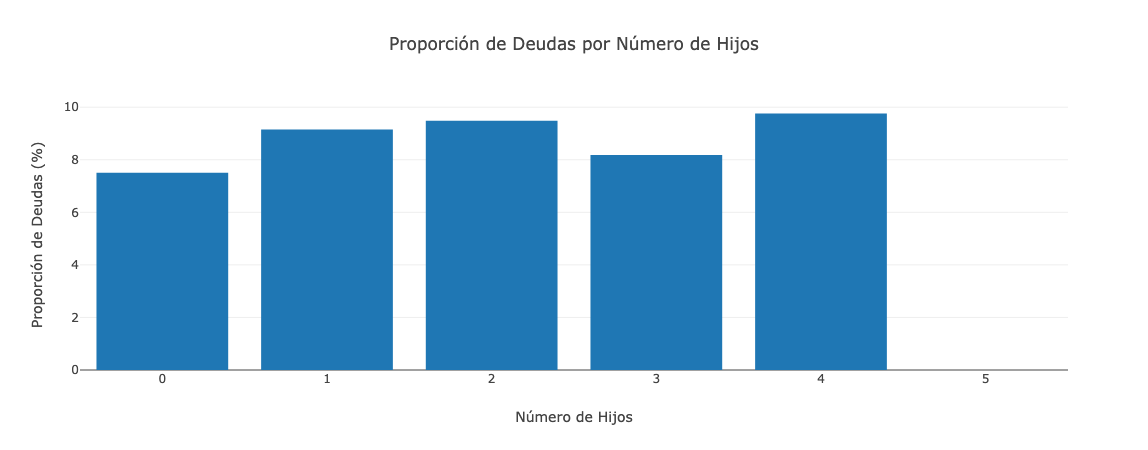

In [76]:
ruta_imagen = './newplot.png'
Image(filename=ruta_imagen)

**¿Existe una correlación entre la situación familiar y el pago a tiempo?**

In [77]:
# Calcular la tasa de incumplimiento basada en el estado familiar

proporcion_deudas_por_estado_civil = df_copia.groupby('family_status')['debt'].mean()

for estado_civil, porcentaje in proporcion_deudas_por_estado_civil.items():
    print(f'Para el estado civil "{estado_civil}", la proporción de deudas es: {porcentaje:.2%}')

Para el estado civil "civil_partnership", la proporción de deudas es: 9.29%
Para el estado civil "divorced", la proporción de deudas es: 7.11%
Para el estado civil "married", la proporción de deudas es: 7.52%
Para el estado civil "unmarried", la proporción de deudas es: 9.74%
Para el estado civil "widow_widower", la proporción de deudas es: 6.56%


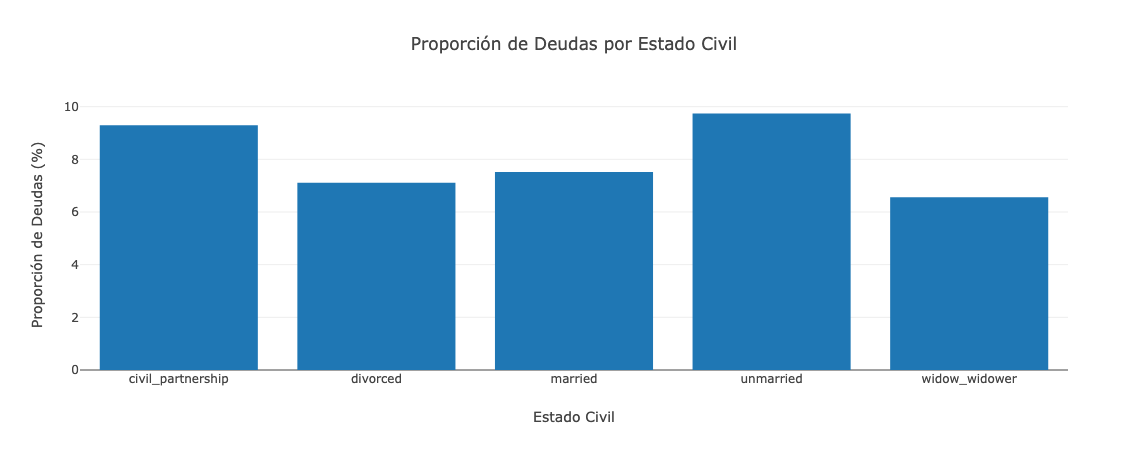

In [78]:
ruta_imagen = './newplot (1).png'
Image(filename=ruta_imagen)

**¿Existe una correlación entre el nivel de ingresos y el pago a tiempo?**

In [79]:
# Calcular la tasa de incumplimiento basada en el nivel de ingresos

rangos_ingresos = [0, 20000, 40000, 60000, 80000, 100000, float('inf')]

etiquetas = ['0-20000', '20000-40000', '40000-60000', '60000-80000', '80000-100000', 'Más de 100000']
df_copia['ingresos_rango'] = pd.cut(df_copia['total_income'], bins=rangos_ingresos, labels=etiquetas, right=False)
proporcion_deudas_por_ingresos = df_copia.groupby('ingresos_rango')['debt'].mean()

for rango, porcentaje in proporcion_deudas_por_ingresos.items():
    print(f'Para el rango de ingresos "{rango}", la proporción de deudas es: {porcentaje:.2%}')

Para el rango de ingresos "0-20000", la proporción de deudas es: 8.25%
Para el rango de ingresos "20000-40000", la proporción de deudas es: 8.28%
Para el rango de ingresos "40000-60000", la proporción de deudas es: 7.29%
Para el rango de ingresos "60000-80000", la proporción de deudas es: 5.33%
Para el rango de ingresos "80000-100000", la proporción de deudas es: 6.50%
Para el rango de ingresos "Más de 100000", la proporción de deudas es: 6.06%


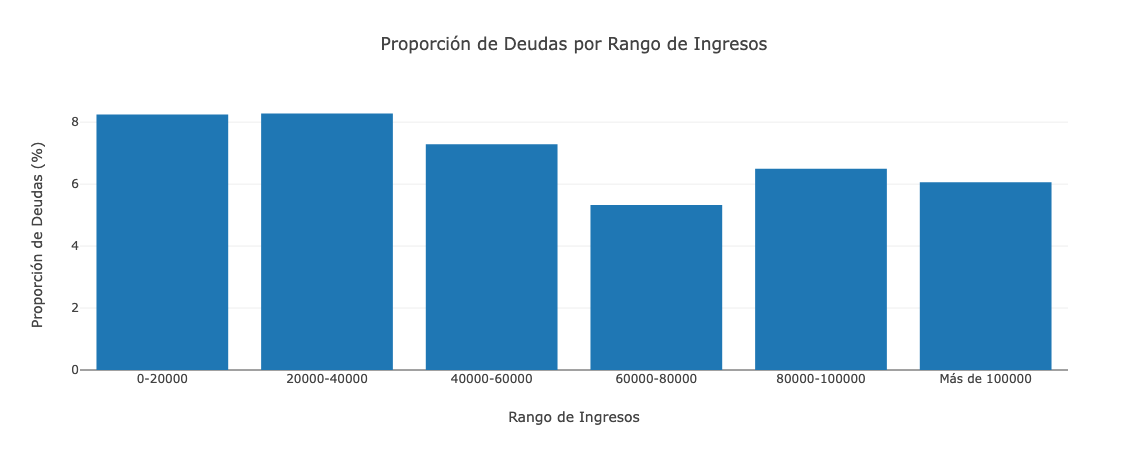

In [80]:
ruta_imagen = './newplot (2).png'
Image(filename=ruta_imagen)

**¿Cómo afecta el propósito del crédito a la tasa de incumplimiento?**

In [84]:
# Calcular tasa de incumplimiento para cada propósito del crédito 

proporcion_deudas_por_purpose = df_copia.groupby('purpose')['debt'].mean()

for proposito, porcentaje in proporcion_deudas_por_purpose.items():
    print(f'Para el propósito "{proposito}", la proporción de deudas es: {porcentaje:.2%}')

Para el propósito "education_fee", la proporción de deudas es: 9.20%
Para el propósito "purchase_car", la proporción de deudas es: 9.34%
Para el propósito "real_estate", la proporción de deudas es: 7.21%
Para el propósito "wedding_ceremony", la proporción de deudas es: 7.92%


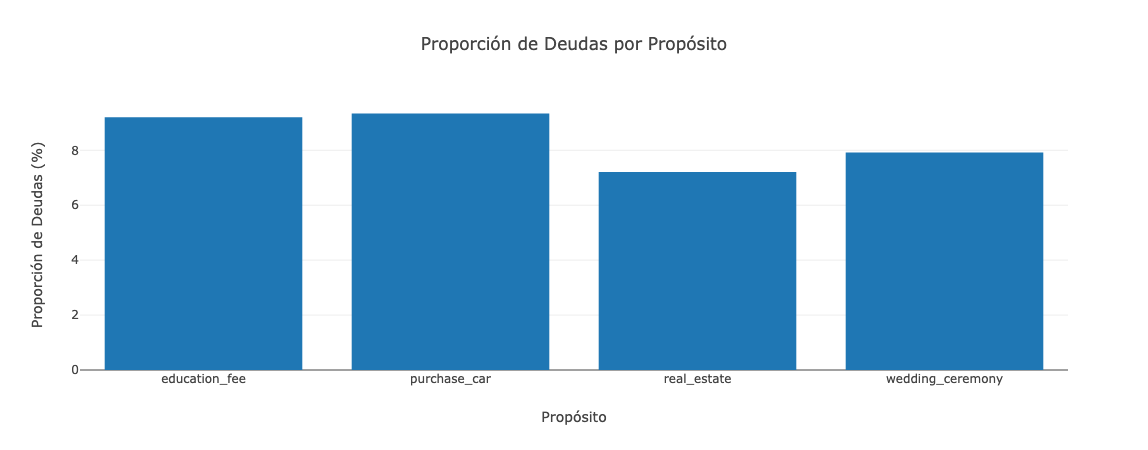

In [82]:
ruta_imagen = './newplot (3).png'
Image(filename=ruta_imagen)

# Conclusión general 

<div style="background-color: #ADD8E6; padding: 10px;">

Hemos trabajado con un conjunto de datos que contiene información sobre clientes y préstamos. Inicialmente, <b>creamos dos DataFrames</b>, uno para <b>eliminar duplicados</b> (<code>df_sin_duplicados</code>) y otro para <b>realizar imputaciones</b> (<code>df_copia</code>) en los valores ausentes.

Durante el análisis, notamos que algunos valores en la columna <code>days_employed</code> eran <b>negativos</b>, lo que representaba aproximadamente el <b>74%</b> del conjunto de datos. Decidimos corregir estos valores asumiendo que se trataba de un <b>marcador</b> para diferenciar entre clientes jubilados/sin empleo y otros clientes. Después de la corrección, la proporción de valores negativos en <code>days_employed</code> se redujo a <b>0%</b>.<br>
<br>
Hemos evaluado la relación entre diferentes variables y la proporción de deudas. Algunos de los hallazgos destacados incluyen:<br>

<li>La proporción de deudas no muestra una correlación clara con el <b>número de hijos</b>, pero aquellos con 5 hijos parecen no tener deudas
<li>El <b>estado civil</b> tiene una leve influencia, con una proporción ligeramente más alta de deudas por personas casadas y en uniones civiles
<li>La proporción de deudas parece tener una relación inversa con el <b>nivel de ingresos</b>, siendo más alta en los rangos de ingresos más bajos
<li>El <b>propósito del crédito</b> también puede influir en la proporción de deudas, con ciertos propósitos mostrando una proporción más alta de deudas<br>
<br>
Sin embargo, es importante señalar que los <b>valores extremadamente altos</b> en <code>days_employed</code> y algunos <b>valores inusuales</b> en otras columnas pueden requerir una mayor investigación para garantizar la calidad de los datos. En resumen, hemos avanzado en la exploración y análisis de los datos, y estas conclusiones preliminares nos permitirán realizar un análisis más profundo y tomar decisiones informadas en el futuro.